In [49]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import matplotlib.pyplot as plt
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lstm-datasets-multivariate-univariate/pollution_test_data1.csv
/kaggle/input/lstm-datasets-multivariate-univariate/LSTM-Multivariate_pollution.csv
/kaggle/input/residual-lstm-history/16x5_history.json
/kaggle/input/residual-lstm-history/16x3_history.json
/kaggle/input/residual-lstm-history/300t_32x3_history.json
/kaggle/input/residual-lstm-model/rltmmodel_16x5_best.pth
/kaggle/input/residual-lstm-model/rltmmodel_300t_32x3_best.pth
/kaggle/input/residual-lstm-model/rltmmodel_16x3_best.pth


In [50]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm.auto import tqdm
from timm.scheduler import CosineLRScheduler
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import time
from sklearn.metrics import average_precision_score
from timm.scheduler import CosineLRScheduler
plt.style.use("ggplot")
import json
from pyarrow.parquet import ParquetFile
import pyarrow as pa
import ctypes
import gc
import os
import torch.jit as jit
import torch.autograd as autograd
import random 
from torch.autograd import Variable

In [76]:
files = ["16x3","300t_32x3","16x5"]
train_losses = []
valid_losses = []
for file in files:
    with open("/kaggle/input/residual-lstm-history/"+file+'_history.json') as f:
        d = json.load(f)
    if file == "300t_32x3" or file == "16x3":
        d["train_loss"] = d["train_loss"][:150]
        d["valid_loss"] = d["valid_loss"][:150]
    train_losses.append(d["train_loss"][::5])
    valid_losses.append(d["valid_loss"][::5])
train_losses

[[0.16821385540861022,
  0.026115603215960674,
  0.007841392319988396,
  0.0072262403271505255,
  0.006861008202489148,
  0.006595519843895615,
  0.006339918909527083,
  0.006245049504051779,
  0.006133478958478196,
  0.005961100899487292,
  0.005750751549625432,
  0.005681643603429361,
  0.005412939326609935,
  0.005185735174950294,
  0.005009661336803157,
  0.004837780049226567,
  0.00470715899057883,
  0.00459572100782257,
  0.004490374441744319,
  0.004343541801485719,
  0.004226107568787237,
  0.0041741292703246875,
  0.004071300635401804,
  0.003921799230443013,
  0.0038705621780767115,
  0.003741054963165399,
  0.00366137211345693,
  0.0035816470166659974,
  0.0034985835744358543,
  0.003423034715837671],
 [0.27097988189791977,
  0.08472121403205332,
  0.01035759077713069,
  0.008116677844334034,
  0.007664549464638293,
  0.007313651301323835,
  0.007105321943976293,
  0.006983722027018213,
  0.006808692403383565,
  0.006687534835993802,
  0.006818171645889919,
  0.0065712067119

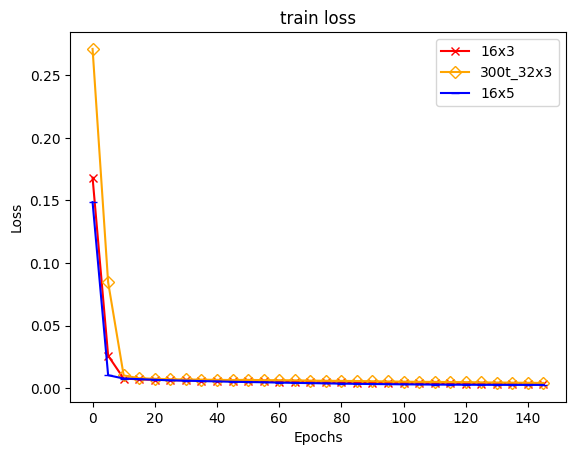

In [77]:
plt.figure()
plot_type = ["x","D","_"]
plt.style.use('default')
colors = ["r","orange","b"]
for train_loss, label, pt ,color in zip(train_losses, files, plot_type, colors): 
    
    plt.plot(range(0,len(train_loss*5),5), train_loss,color = color ,marker = pt,markerfacecolor='none',label=label)
    plt.title("train loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
plt.legend()

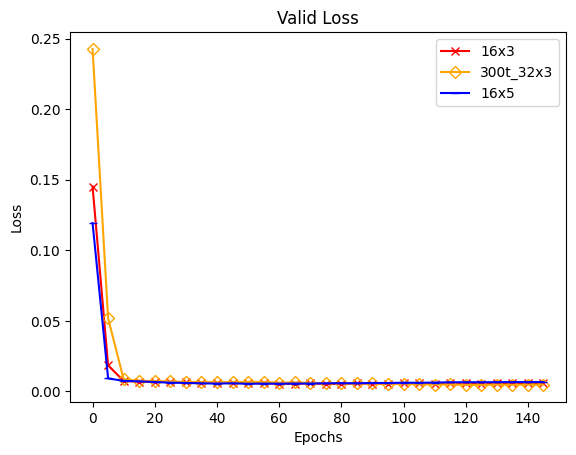

In [78]:

plt.figure()
plt.style.use('default')
plot_type = ["x", "D", "_"]
colors = ["r", "orange", "b"]
for valid_loss, label, pt, color in zip(valid_losses, files, plot_type, colors): 
    plt.plot(range(0, len(valid_loss * 5), 5), valid_loss, color=color, marker=pt, markerfacecolor='none', label=label)
    plt.title("Valid Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
plt.grid(False)
plt.legend()
plt.show()


In [79]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
use_cuda = torch.cuda.is_available()
device

'cpu'

In [80]:
SEED = 1
os.environ["PL_GLOBAL_SEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [81]:
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [82]:
df_train = pd.read_csv("/kaggle/input/lstm-datasets-multivariate-univariate/LSTM-Multivariate_pollution.csv")
df_train

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...,...
43795,2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43796,2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43797,2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43798,2014-12-31 22:00:00,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [83]:
df_train = df_train.drop(columns = ["date"])

In [84]:
df_test = pd.read_csv("/kaggle/input/lstm-datasets-multivariate-univariate/pollution_test_data1.csv")
df_test

,dew,temp,press,wnd_dir,wnd_spd,snow,rain,pollution
0,-16,4,1027,SE,3.58,0,0,128
1,-17,5,1027,SE,7.60,0,0,77
2,-16,4,1027,SE,9.39,0,0,65
3,-16,1,1028,cv,0.89,0,0,79
4,-14,0,1028,NE,1.79,0,0,93
...,...,...,...,...,...,...,...,...
341,-23,-2,1034,NW,231.97,0,0,8
342,-22,-3,1034,NW,237.78,0,0,10
343,-22,-3,1034,NW,242.70,0,0,10
344,-22,-4,1034,NW,246.72,0,0,8


In [85]:
def cleaning(data: pd.DataFrame)->pd.DataFrame:
    print("before cleaning data")
    print(data.isna().sum())
    print("len of data is: ",len(data))
    
    print("after cleaning data")
    data.dropna()
    print(data.isna().sum())
    print("len of data is: ",len(data))
    return data
df_train = cleaning(df_train)

before cleaning data
pollution    0
dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
dtype: int64
len of data is:  43800
after cleaning data
pollution    0
dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
dtype: int64
len of data is:  43800


In [86]:
df_train = df_train.drop(columns = ["snow"])
df_test = df_test.drop(columns = ["snow"])

In [87]:
#one hot encoding
from sklearn.preprocessing import OneHotEncoder
catogorical_columns = df_train.select_dtypes(include = ['object']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False)
encoder.fit(df_train[catogorical_columns])
train_encoded = encoder.transform(df_train[catogorical_columns])
test_encoded = encoder.transform(df_test[catogorical_columns])

train_encoded_df = pd.DataFrame(train_encoded, columns = encoder.get_feature_names_out(catogorical_columns))
test_encoded_df = pd.DataFrame(test_encoded, columns = encoder.get_feature_names_out(catogorical_columns))

df_train = pd.concat([df_train, train_encoded_df], axis = 1)
df_test = pd.concat([df_test, test_encoded_df], axis = 1)

df_train = df_train.drop(catogorical_columns, axis = 1)
df_test = df_test.drop(catogorical_columns, axis = 1)

df_test

,dew,temp,press,wnd_spd,rain,pollution,wnd_dir_NE,wnd_dir_NW,wnd_dir_SE,wnd_dir_cv
0,-16,4,1027,3.58,0,128,0.0,0.0,1.0,0.0
1,-17,5,1027,7.60,0,77,0.0,0.0,1.0,0.0
2,-16,4,1027,9.39,0,65,0.0,0.0,1.0,0.0
3,-16,1,1028,0.89,0,79,0.0,0.0,0.0,1.0
4,-14,0,1028,1.79,0,93,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
341,-23,-2,1034,231.97,0,8,0.0,1.0,0.0,0.0
342,-22,-3,1034,237.78,0,10,0.0,1.0,0.0,0.0
343,-22,-3,1034,242.70,0,10,0.0,1.0,0.0,0.0
344,-22,-4,1034,246.72,0,8,0.0,1.0,0.0,0.0


In [88]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() #defualt is (0,1)

cols = [i for i in range(5)]
columns = df_train.columns[cols].tolist()

df_train[columns] = scaler.fit_transform(df_train[columns])
df_test[columns] = scaler.transform(df_test[columns])

df_train

,pollution,dew,temp,press,wnd_spd,rain,wnd_dir_NE,wnd_dir_NW,wnd_dir_SE,wnd_dir_cv
0,0.129779,0.352941,0.245902,0.527273,0.002290,0,0.0,0.0,1.0,0.0
1,0.148893,0.367647,0.245902,0.527273,0.003811,0,0.0,0.0,1.0,0.0
2,0.159960,0.426471,0.229508,0.545455,0.005332,0,0.0,0.0,1.0,0.0
3,0.182093,0.485294,0.229508,0.563636,0.008391,0,0.0,0.0,1.0,0.0
4,0.138833,0.485294,0.229508,0.563636,0.009912,0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
43795,0.008048,0.250000,0.278689,0.781818,0.395659,0,0.0,1.0,0.0,0.0
43796,0.010060,0.264706,0.262295,0.781818,0.405588,0,0.0,1.0,0.0,0.0
43797,0.010060,0.264706,0.262295,0.781818,0.413996,0,0.0,1.0,0.0,0.0
43798,0.008048,0.264706,0.245902,0.781818,0.420866,0,0.0,1.0,0.0,0.0


In [89]:
train_size = int(len(df_train) * 0.8)
num_epochs = 150
steps = train_size*num_epochs
warmup_steps = int(steps*0.2)
train= df_train.iloc[:train_size, :]
val = df_train.iloc[train_size:, :]
train

,pollution,dew,temp,press,wnd_spd,rain,wnd_dir_NE,wnd_dir_NW,wnd_dir_SE,wnd_dir_cv
0,0.129779,0.352941,0.245902,0.527273,0.002290,0,0.0,0.0,1.0,0.0
1,0.148893,0.367647,0.245902,0.527273,0.003811,0,0.0,0.0,1.0,0.0
2,0.159960,0.426471,0.229508,0.545455,0.005332,0,0.0,0.0,1.0,0.0
3,0.182093,0.485294,0.229508,0.563636,0.008391,0,0.0,0.0,1.0,0.0
4,0.138833,0.485294,0.229508,0.563636,0.009912,0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
35035,0.022133,0.308824,0.426230,0.400000,0.195540,0,0.0,1.0,0.0,0.0
35036,0.018109,0.279412,0.426230,0.418182,0.203948,0,0.0,1.0,0.0,0.0
35037,0.023139,0.279412,0.426230,0.418182,0.213877,0,0.0,1.0,0.0,0.0
35038,0.020121,0.279412,0.409836,0.418182,0.222285,0,0.0,1.0,0.0,0.0


In [90]:
window_size = 11#24*7

# TrainSet
X_sequences = []
y_values = []

n_past = 11
n_future = 1

for i in range(n_past, len(train) - n_future+1):
    X_seq = train.iloc[i - n_past:i].drop(columns=["pollution"]).values
    y_val = train.iloc[i + n_future - 1:i + n_future].pollution
    X_sequences.append(X_seq)
    y_values.append(y_val)

X_train = np.array(X_sequences)
y_train = np.array(y_values)

# ValidSet
X_sequences = []
y_values = []

for i in range(n_past, len(val) - n_future+1):
    X_seq = val.iloc[i - n_past:i].drop(columns=["pollution"]).values
    y_val = val.iloc[i + n_future - 1:i + n_future].pollution
    X_sequences.append(X_seq)
    y_values.append(y_val)

X_valid = np.array(X_sequences)
y_valid = np.array(y_values)

# TestSet
X_sequences = []
y_values = []
for i in range(n_past, len(df_test) - n_future+1):
    X_seq = df_test.iloc[ i- n_past:i].drop(columns=["pollution"]).values
    Y_val = df_test.iloc[i + n_future - 1:i + n_future]['pollution']
    X_sequences.append(X_seq)
    y_values.append(Y_val)

X_test = np.array(X_sequences)
y_test = np.array(y_values)

print('train_data'.center(50, '-'))
print(X_train.shape)
print(y_train.shape)
print('test_data'.center(50, '-'))
print(X_test.shape)
print(y_test.shape)

--------------------train_data--------------------
(35029, 11, 9)
(35029, 1)
--------------------test_data---------------------
(335, 11, 9)
(335, 1)


In [91]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_valid = torch.from_numpy(X_valid.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32).reshape(-1,1))
y_valid = torch.from_numpy(y_valid.astype(np.float32).reshape(-1,1))
y_test = torch.from_numpy(y_test.astype(np.float32).reshape(-1,1))

In [92]:
class ResLSTMCell(jit.ScriptModule):
    def __init__(self, input_size, hidden_size, dropout=0.):
        super(ResLSTMCell, self).__init__()
        self.register_buffer('input_size', torch.Tensor([input_size]))
        self.register_buffer('hidden_size', torch.Tensor([hidden_size]))
        self.weight_ii = nn.Parameter(torch.randn(3 * hidden_size, input_size))
        self.weight_ic = nn.Parameter(torch.randn(3 * hidden_size, hidden_size))
        self.weight_ih = nn.Parameter(torch.randn(3 * hidden_size, hidden_size))
        self.bias_ii = nn.Parameter(torch.randn(3 * hidden_size))
        self.bias_ic = nn.Parameter(torch.randn(3 * hidden_size))
        self.bias_ih = nn.Parameter(torch.randn(3 * hidden_size))
        self.weight_hh = nn.Parameter(torch.randn(1 * hidden_size, hidden_size))
        self.bias_hh = nn.Parameter(torch.randn(1 * hidden_size))
        self.weight_ir = nn.Parameter(torch.randn(hidden_size, input_size))
        #self.dropout_layer = nn.Dropout(dropout)
        self.dropout = dropout

    @jit.script_method
    def forward(self, input, hidden):
        # type: (Tensor, Tuple[Tensor, Tensor]) -> Tuple[Tensor, Tuple[Tensor, Tensor]]
        hx, cx = hidden[0].squeeze(0), hidden[1].squeeze(0)

        ifo_gates = (torch.mm(input, self.weight_ii.t()) + self.bias_ii +
                     torch.mm(hx, self.weight_ih.t()) + self.bias_ih +
                     torch.mm(cx, self.weight_ic.t()) + self.bias_ic)
        ingate, forgetgate, outgate = ifo_gates.chunk(3, 1)
        
        cellgate = torch.mm(hx, self.weight_hh.t()) + self.bias_hh
        
        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate)
        cellgate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)

        cy = (forgetgate * cx) + (ingate * cellgate)
        ry = torch.tanh(cy)

        if self.input_size == self.hidden_size:
              hy = outgate * (ry + input)
        else:
              hy = outgate * (ry + torch.mm(input, self.weight_ir.t()))
        return hy, (hy, cy)

In [93]:
class ResLSTMLayer(jit.ScriptModule):
    def __init__(self, input_size, hidden_size, dropout=0.):
        super(ResLSTMLayer, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        #self.cell = LSTMCell(input_size, hidden_size, dropout=0.)
        self.cell = ResLSTMCell(input_size, hidden_size, dropout=0.)

    @jit.script_method
    def forward(self, input, hidden):
        # type: (Tensor, Tuple[Tensor, Tensor]) -> Tuple[Tensor, Tuple[Tensor, Tensor]]
        inputs = input.unbind(0)
        outputs = torch.jit.annotate(List[Tensor], [])
        for i in range(len(inputs)):
            out, hidden = self.cell(inputs[i], hidden)
            outputs += [out]
        outputs = torch.stack(outputs)
        # print("outputs.size()", outputs.size())
        return outputs, hidden

In [94]:
class ResLSTM(nn.Module):

    def __init__(self, n_input, n_hidden, n_layers, dropout=0, batch_first=False):
        super().__init__()
        self.batch_first = batch_first
        layers = []
        for i in range(n_layers):
            if i == 0:
                c = ResLSTMLayer(n_input, n_hidden, dropout=dropout)
            else:
                c = ResLSTMLayer(n_hidden, n_hidden, dropout=dropout)
            layers.append(c)
        self.cells = nn.Sequential(*layers)

    def forward(self, inputs, hidden=None):
        # if self.batch_first:
        # inputs = inputs.cuda().contiguous()
        inputs = inputs.transpose(0, 1)
            # inputs = inputs.permute(1, 0,2).cuda()
        outputs = []
        for i, cell in enumerate(self.cells):

            # first layer: ResLSTM inputs size before torch.Size([28, 32, 1])
            # first layer: ResLSTM inputs size after torch.Size([28, 32, 64])
            # outputs from each layer is used as inputs to the next layer
            inputs, _ = self.res_layer(cell, inputs)

            # inputs[-1:] size torch.Size([1, 32, 64])
            # outputs have the length of num_layers
            outputs.append(inputs[-1:].squeeze())
            
        outputs = torch.stack(outputs)

        if self.batch_first:
            inputs = inputs.transpose(0, 1)
        # inputs is the output from the last layer
        # outputs is the output at the last time step from all layers
        return inputs, outputs

    def res_layer(self, cell, inputs, hidden=None):

        n_steps = len(inputs)
        batch_size = inputs[0].size(0)
        hidden_size = cell.hidden_size

        if hidden is None:
            outputs, hidden = self._apply_cell(inputs, cell, batch_size, hidden_size)
        else:
            outputs, hidden = self._apply_cell(inputs, cell, batch_size, hidden_size,
                                                       hidden=hidden)
        return outputs, hidden

    def _apply_cell(self, inputs, cell, batch_size, hidden_size, hidden=None):
        if hidden is None:
            c, m = self.init_hidden(batch_size, hidden_size)
            hidden = (c.unsqueeze(0), m.unsqueeze(0))
        
        outputs, hidden = cell(inputs, hidden) 
        
        return outputs, hidden


    def init_hidden(self, batch_size, hidden_dim):
        
        hidden = autograd.Variable(torch.zeros(batch_size, hidden_dim))
        if use_cuda:
            hidden = hidden.cuda()
        memory = autograd.Variable(torch.zeros(batch_size, hidden_dim))
        if use_cuda:
            memory = memory.cuda()
        return hidden, memory

In [95]:
class seq2vec(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = ResLSTM(n_input=input_size, n_hidden=hidden_size, n_layers=num_layers, dropout=0.2, batch_first=True)
        if use_cuda:
            self.fc = nn.Linear(hidden_size, 1).cuda()
        else:
            self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        
        out, hidden = self.lstm(x)
        hidden = hidden[-1:].squeeze()
        out = out[:, -1, :]
        pred = self.fc(out)
        return pred#.squeeze()

In [96]:
from timm.scheduler import CosineLRScheduler


model_1 = seq2vec(input_size=9,hidden_size=16,num_layers=3).to(device)
model_2 = seq2vec(input_size=9,hidden_size=32,num_layers=3).to(device)
model_3 = seq2vec(input_size=9,hidden_size=16,num_layers=5).to(device)
# model = MultiResidualBiGRU(input_size=9,hidden_size=16,out_size=1,n_layers=3).to(device)

optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=1e-3,weight_decay = 0)
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=1e-3,weight_decay = 0)
optimizer_3 = torch.optim.Adam(model_3.parameters(), lr=1e-3,weight_decay = 0)


steps = train_size*num_epochs
scheduler_1 = CosineLRScheduler(optimizer_1,t_initial= steps,warmup_t=warmup_steps, warmup_lr_init=1e-5,lr_min=2e-8,)
scheduler_2 = CosineLRScheduler(optimizer_2,t_initial= steps,warmup_t=warmup_steps, warmup_lr_init=1e-5,lr_min=2e-8,)
scheduler_3 = CosineLRScheduler(optimizer_3,t_initial= steps,warmup_t=warmup_steps, warmup_lr_init=1e-5,lr_min=2e-8,)
# scheduler  = torch.optim.lr_scheduler.StepLR(optimizer, 5, 0.5, last_epoch=-1)
criterion = nn.MSELoss().to(device)

# model

In [97]:
from torch.utils.data import TensorDataset, DataLoader
batch_size = 32

train_set = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_set,
                          batch_size=batch_size,
                          shuffle=True,
                          drop_last=True,
                          )

val_set = TensorDataset(X_valid, y_valid)
val_loader = DataLoader(val_set,
                          batch_size=batch_size,
                          shuffle=True,
                          drop_last=True,
                          )
test_set = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_set,
                          batch_size=1,
                          shuffle=True,
                          drop_last=True,
                          )

In [99]:
model_1.load_state_dict(torch.load(f'/kaggle/input/residual-lstm-model/rltmmodel_16x3_best.pth',map_location=device))
model_2.load_state_dict(torch.load(f'/kaggle/input/residual-lstm-model/rltmmodel_300t_32x3_best.pth',map_location=device))
model_3.load_state_dict(torch.load(f'/kaggle/input/residual-lstm-model/rltmmodel_16x5_best.pth',map_location=device))

<All keys matched successfully>

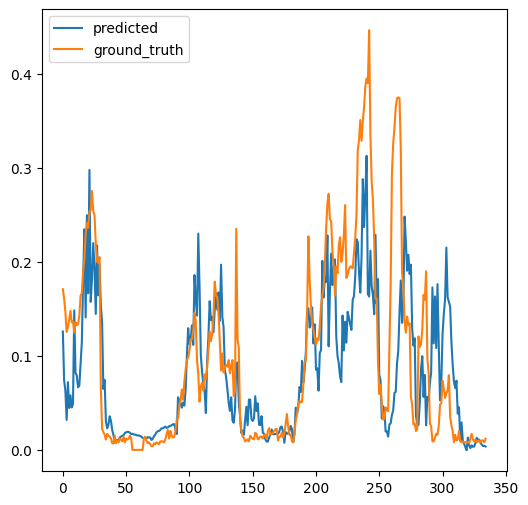

In [100]:
with torch.no_grad():
#     h = None
    predicted = model_1(X_test.to(device))
#     h = [hi.detach() for hi in h]
plt.figure(figsize=(6, 6))
plt.plot(predicted.detach().cpu().numpy(), label='predicted')
plt.plot(y_test, label='ground_truth')
plt.legend()
plt.show()

In [101]:
predict = predicted.detach().cpu().numpy()
rmse = np.sqrt(mean_squared_error(y_test, predict))
mae = mean_absolute_error(y_test, predict)
r2 = r2_score(y_test, predict)
print(rmse)
print(mae)
print(r2)

0.071166426
0.04502272
0.4867724166367833


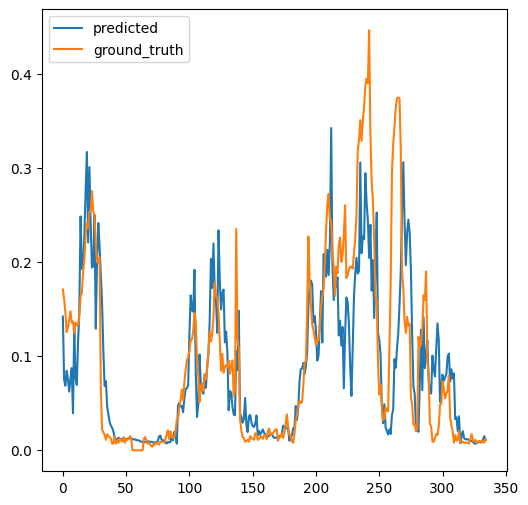

In [102]:
with torch.no_grad():
#     h = None
    predicted = model_2(X_test.to(device))
#     h = [hi.detach() for hi in h]
plt.figure(figsize=(6, 6))
plt.plot(predicted.detach().cpu().numpy(), label='predicted')
plt.plot(y_test, label='ground_truth')
plt.legend()
plt.show()

In [103]:
predict = predicted.detach().cpu().numpy()
rmse = np.sqrt(mean_squared_error(y_test, predict))
mae = mean_absolute_error(y_test, predict)
r2 = r2_score(y_test, predict)
print(rmse)
print(mae)
print(r2)

0.06383853
0.039162714
0.5870234187165068


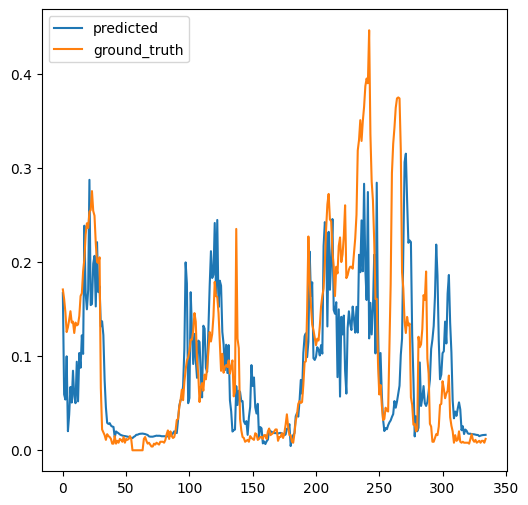

In [104]:
with torch.no_grad():
#     h = None
    predicted = model_3(X_test.to(device))
#     h = [hi.detach() for hi in h]
plt.figure(figsize=(6, 6))
plt.plot(predicted.detach().cpu().numpy(), label='predicted')
plt.plot(y_test, label='ground_truth')
plt.legend()
plt.show()

In [105]:
predict = predicted.detach().cpu().numpy()
rmse = np.sqrt(mean_squared_error(y_test, predict))
mae = mean_absolute_error(y_test, predict)
r2 = r2_score(y_test, predict)
print(rmse)
print(mae)
print(r2)

0.07908106
0.050052445
0.36626945185123105
